In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import shutil
import numpy as np

import matplotlib.pyplot as plt

In [4]:
%matplotlib inline
import sys
sys.path.append('..')

In [5]:
from sarpy.datasets import load_emnist

In [6]:
X_train, y_train, X_test, y_test, X_valid, y_valid, mapping, nb_classes = load_emnist('mnist', validation=True)

reshape testing: 100%|██████████| 10000/10000 [00:00<00:00, 35970.00it/s]


Train size: 50000
Test size: 10000
Validation size: 10000
# classes: 10


In [7]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose

/home/ricardo/miniconda3/envs/sarpy/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [8]:
class DigitsDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        image = self.X[idx].reshape((1, 28, 28))
        label = np.asscalar(self.y[idx])
        sample = {'image': image, 'label': label}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample
    
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        return {'image': torch.from_numpy(image),
#         return {'image': torch.from_numpy(np.flip(image.transpose((0, 1, 2)),axis=0).copy()),
                'label': torch.tensor(label)}

In [9]:
def get_dataloaders(batch_size, inverse_resize_rate, transforms=[]):
    transform_train = Compose([])
    for t in transforms:
        transform_train.transforms.append(t)
    transform_train.transforms.append(ToTensor())
    
    transform_test = Compose([
        ToTensor()
    ])

    digits_dataset_train = DigitsDataset(X_train, y_train, transform=transform_train)
    digits_dataset_test = DigitsDataset(X_test, y_test, transform=transform_test)

    dataloader_train = DataLoader(digits_dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)
    dataloader_test = DataLoader(digits_dataset_test, batch_size=batch_size, shuffle=True, num_workers=4)

    return dataloader_train, dataloader_test

In [10]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, n):
        self.n = n
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)        
        self.dropout1 = nn.Dropout2d(p=0.25)
        
        self.fc1 = nn.Linear(64*(n//4)**2, 200)
        self.dropout2 = nn.Dropout(p=0.25)
        
        self.fc2 = nn.Linear(200, 100)
        self.dropout3 = nn.Dropout(p=0.25)
        
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):        
        x = F.relu(self.conv1(x)) 
        x = self.pool1(x)
        x = F.relu(self.conv2(x))        
        x = self.pool2(x)
        x = self.dropout1(x)
        x = x.view(-1, 64 * (self.n // 4) ** 2)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.dropout3(x)
        x = self.fc3(x)
        return x

In [11]:
import torch.optim as optim


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def run_training(dataloader_train, dataloader_test, image_size, batch_size, epochs):
    net = Net(n=image_size)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)


    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(dataloader_train, 0):
            # get the inputs
            inputs, labels = data['image'], data['label']
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if batch_size*(i+1) % 5000 == 0:    # print every 5000 mini-batches
                correct = 0
                total = 1
                with torch.no_grad():
                    for data in dataloader_test:
                        inputs, labels = data['image'], data['label']
                        inputs, labels = inputs.to(device), labels.to(device)
                        outputs = net(inputs)
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()

                print('[%d, %5d] loss: %.3f test acc: %.3f' %
                      (epoch + 1, batch_size*(i+1), running_loss / 5000, (100*correct/total)))
                running_loss = 0.0

    print('Finished Training')

In [12]:
print(device)

cuda:0


In [42]:
%%time
dataloader_train, dataloader_test = get_dataloaders(batch_size=5, inverse_resize_rate=1)
run_training(dataloader_train=dataloader_train,
             dataloader_test=dataloader_test,
             image_size=28,
             batch_size=5,
             epochs=2
            )

[1,  5000] loss: 0.150 test acc: 91.281
[1, 10000] loss: 0.072 test acc: 90.051
[1, 15000] loss: 0.054 test acc: 92.991
[1, 20000] loss: 0.049 test acc: 94.691
[1, 25000] loss: 0.051 test acc: 93.051
[1, 30000] loss: 0.042 test acc: 94.411
[1, 35000] loss: 0.043 test acc: 94.301
[1, 40000] loss: 0.044 test acc: 95.510
[1, 45000] loss: 0.040 test acc: 95.090
[1, 50000] loss: 0.032 test acc: 95.620
[2,  5000] loss: 0.035 test acc: 95.750
[2, 10000] loss: 0.037 test acc: 94.331
[2, 15000] loss: 0.033 test acc: 95.640
[2, 20000] loss: 0.032 test acc: 95.830
[2, 25000] loss: 0.036 test acc: 94.701
[2, 30000] loss: 0.034 test acc: 96.380
[2, 35000] loss: 0.030 test acc: 95.820
[2, 40000] loss: 0.034 test acc: 96.410
[2, 45000] loss: 0.037 test acc: 95.650
[2, 50000] loss: 0.040 test acc: 95.930
Finished Training
CPU times: user 2min 38s, sys: 13.6 s, total: 2min 52s
Wall time: 3min 3s


# Image augmentation

In [43]:
X_train[0].shape

(28, 28, 1)

In [13]:
import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np

In [44]:
class ImageAugmentation(object):
    """Convert ndarrays in sample to Tensors."""
    def __init__(self):
        self.seq = iaa.Sequential([
#             iaa.Fliplr(0.5), # horizontal flips
            iaa.Crop(percent=(0, 0.1)), # random crops
            # Small gaussian blur with random sigma between 0 and 0.5.
            # But we only blur about 50% of all images.
            iaa.Sometimes(0.5,
                iaa.GaussianBlur(sigma=(0, 0.5))
            ),
            # Strengthen or weaken the contrast in each image.
            iaa.ContrastNormalization((0.75, 1.5)),
            # Add gaussian noise.
            # For 50% of all images, we sample the noise once per pixel.
            # For the other 50% of all images, we sample the noise per pixel AND
            # channel. This can change the color (not only brightness) of the
            # pixels.
            iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
            # Make some images brighter and some darker.
            # In 20% of all cases, we sample the multiplier once per channel,
            # which can end up changing the color of the images.
            iaa.Multiply((0.8, 1.2), per_channel=0.2),
            # Apply affine transformations to each image.
            # Scale/zoom them, translate/move them, rotate them and shear them.
            iaa.Affine(
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                rotate=(-25, 25),
                shear=(-8, 8)
            )
        ], random_order=True) # apply augmenters in random order

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        
        return {'image': self.seq.augment_images(image),
                'label': label}

In [90]:
%%time
dataloader_train, dataloader_test = get_dataloaders(batch_size=5, inverse_resize_rate=1, transforms=[ImageAugmentation()])
run_training(dataloader_train=dataloader_train,
             dataloader_test=dataloader_test,
             image_size=28,
             batch_size=5,
             epochs=10
            )

[1,  5000] loss: 0.418 test acc: 57.124
[1, 10000] loss: 0.310 test acc: 70.803
[1, 15000] loss: 0.233 test acc: 76.952
[1, 20000] loss: 0.211 test acc: 84.692
[1, 25000] loss: 0.187 test acc: 83.882
[1, 30000] loss: 0.174 test acc: 87.331
[1, 35000] loss: 0.166 test acc: 86.581
[1, 40000] loss: 0.153 test acc: 86.671
[1, 45000] loss: 0.157 test acc: 89.031
[1, 50000] loss: 0.143 test acc: 88.281
[2,  5000] loss: 0.143 test acc: 86.191
[2, 10000] loss: 0.132 test acc: 89.521
[2, 15000] loss: 0.122 test acc: 89.411
[2, 20000] loss: 0.134 test acc: 89.081
[2, 25000] loss: 0.126 test acc: 90.561
[2, 30000] loss: 0.125 test acc: 89.701
[2, 35000] loss: 0.130 test acc: 91.311
[2, 40000] loss: 0.125 test acc: 89.271
[2, 45000] loss: 0.112 test acc: 91.311
[2, 50000] loss: 0.120 test acc: 90.051
[3,  5000] loss: 0.109 test acc: 91.851
[3, 10000] loss: 0.109 test acc: 92.241
[3, 15000] loss: 0.106 test acc: 88.851
[3, 20000] loss: 0.110 test acc: 91.031
[3, 25000] loss: 0.102 test acc: 92.371


# Sample from image augmentation

label: tensor(5)


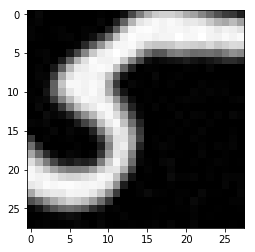

In [96]:
dataloader_train, dataloader_test = get_dataloaders(batch_size=5, inverse_resize_rate=1, transforms=[ImageAugmentation()])

for x in dataloader_train:
    print('label:', x['label'][0])
    plt.imshow(x['image'][0].numpy().reshape((28, 28)), cmap='gray')    
    plt.show()
    break